# Вариант 1. Использование готовой библиотеки DeepFace

В качестве эталоггого решения воспользуюсь готовой библиотекой для распознования лиц DeepFace https://github.com/serengil/deepface/tree/master

В этой библиотеке реализован весь pipeline для распознования лиц:
- детекция лиц
- выраванивание и нормализация
- поиск в базе данных

## План решения

Для решения весь список файлов разобью на тестовую и обучающую выборку. Обучающая выборка будет являться базлй данных и в ней буду искать тестовые изображения. Все найденные изображения будут собираться в список и в качестве предсказанного лейбла для классификации будет выбираться мода всего списка, т.е. чаще всего встречаемый лейбл. По итогам посмотрю на метрики качества.

In [1]:
from deepface import DeepFace
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import random
import cv2 as cv2
from os.path import join
from scipy import stats
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_curve,
    auc,
)

warnings.filterwarnings("ignore")

In [2]:
def view_random_images(cols, rows, path_to_images):
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1), layout="tight")
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid("off")
            ax.axis("off")
            img = cv2.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            size = img.shape
            plt.title(f'{images[random_index].split(".")[0]}, size={size}', fontsize=5)

    plt.show()

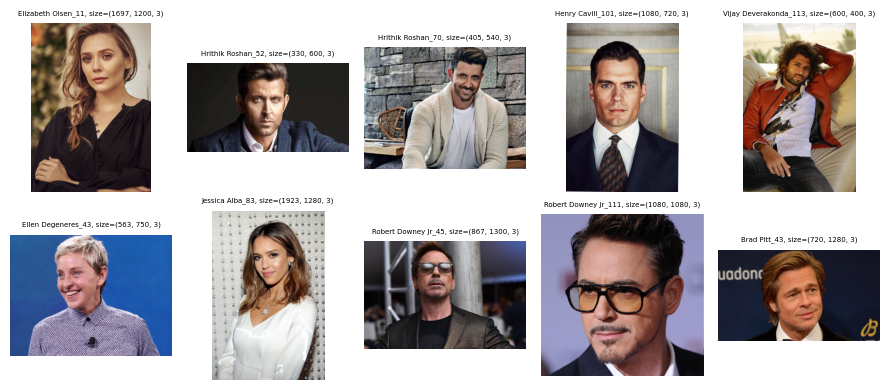

In [3]:
view_random_images(5, 2, "original")

Соберу в отдельный список названия классов (имена людей)

In [4]:
list_of_files = os.listdir("original")
class_names = []
for file in list_of_files:
    label = file.split(".")[0]
    label = label.split("_")[0]
    class_names.append(label)
class_names = list(set(class_names))
class_names = sorted(class_names)
class_names_matches = {}
for idx, name in zip(range(len(class_names)), class_names):
    class_names_matches[name] = idx

In [5]:
train_file_list, test_file_list = train_test_split(
    list_of_files, test_size=0.2, random_state=202
)

In [ ]:
# import shutil
# for filename in train_file_list:
#     full_path = join("original", filename)
#     shutil.copy2(full_path, 'DeepFace_database')

Инициализция базы данных, в итоге все изображения переводятся в вектора и сохраняются в файл pkl. Default model = VGG-Face.

In [6]:
initial = DeepFace.find(
    img_path=join("original", train_file_list[0]),
    db_path="DeepFace_database",
    silent=True,
)

Как раз поиск по базе данных

  0%|          | 0/513 [00:00<?, ?it/s]

Accuracy: 0.846
F1: 0.8597
Recall: 0.846
Precision: 0.8968


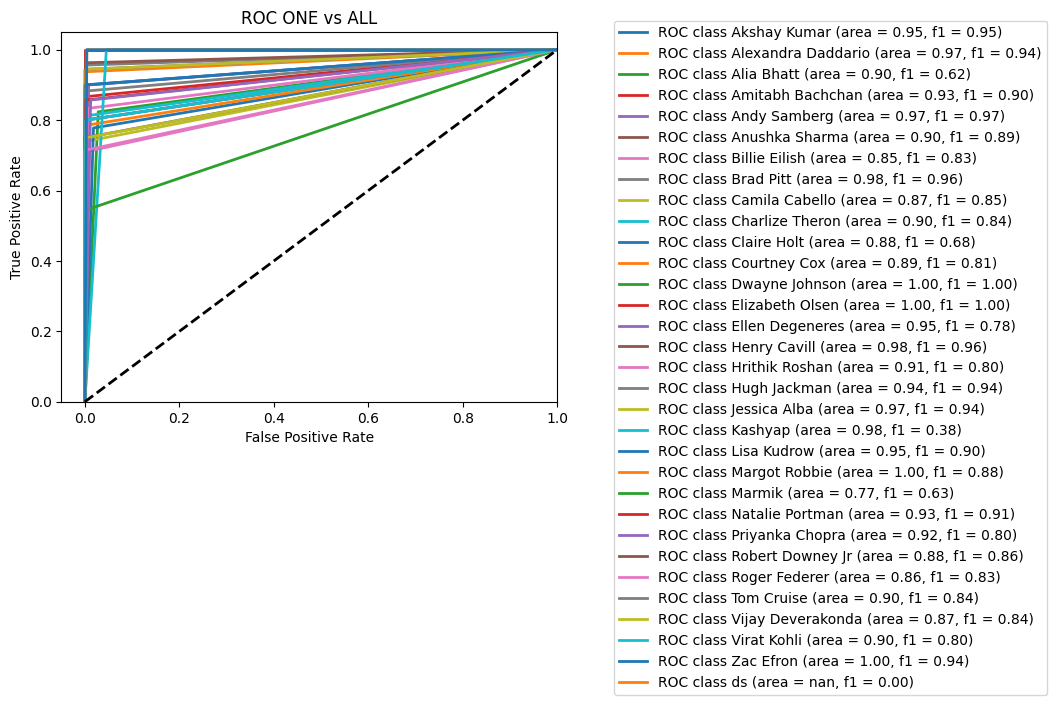

In [7]:
true_labels = []
predicted_labels = []
for filename in tqdm(test_file_list):
    full_path = join("original", filename)
    label = filename.split(".")[0]
    label = label.split("_")[0]
    true_labels.append(label)
    try:
        dfs = DeepFace.find(
                img_path=full_path,
                db_path="original",
                silent = True
            )
        matches = dfs[0]["identity"].tolist()
        labels = [os.path.normpath(i).split(os.sep)[1].split("_")[0] for i in matches]
        labels_numeric = [class_names_matches[x] for x in labels]
        pred_label = stats.mode(labels_numeric)[0]
    except:
        pred_label = random.randrange(0, 31)
    predicted_labels.append(class_names[pred_label])
print(f"Accuracy: {round(accuracy_score(true_labels, predicted_labels), 4)}")
print(f"F1: {round(f1_score(true_labels, predicted_labels, average='weighted'), 4)}")
print(
    f"Recall: {round(recall_score(true_labels, predicted_labels, average='weighted'), 4)}"
)
print(
    f"Precision: {round(precision_score(true_labels, predicted_labels, average='weighted'), 4)}"
)

label_binarizer = LabelBinarizer().fit(class_names)
y_onehot_test = label_binarizer.transform(true_labels)
n_classes = y_onehot_test.shape[1]
y_onehot_pred = label_binarizer.transform(predicted_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
f1 = dict()
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_onehot_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    f1[i] = f1_score(y_onehot_test[:, i], y_onehot_pred[:, i])
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC class {0} (area = {1:0.2f}, f1 = {2:0.2f})"
        "".format(class_names[i], roc_auc[i], f1[i]),
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC ONE vs ALL")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

Посмотрим на примеры фотографий, с классификацией которых библиотека не справилась:

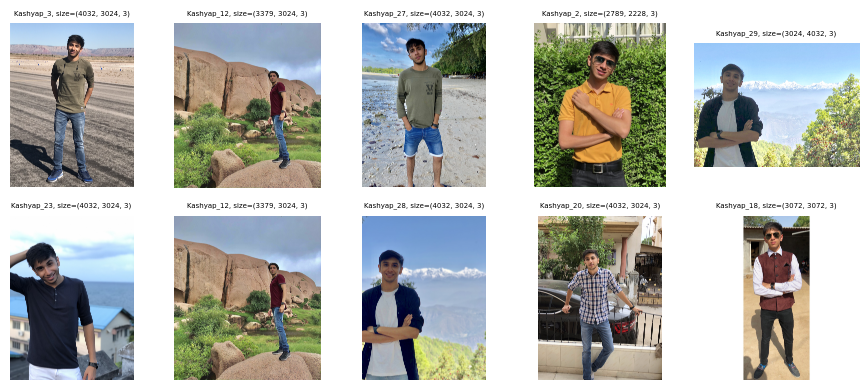

In [9]:
view_random_images(5, 2, "Original Images/Kashyap")

В целом результат очень приличный, по некоторым людям 100%. Хотя можно провести эксперименты с разными моделями и методиками расчета расстояния, но в качестве учебного эталона я оставлю эти метрики:

- Accuracy: 0.846
- F1: 0.8597
- Recall: 0.846
- Precision: 0.8968